In [2]:
import pandas as pd
import numpy as np
import json

In [3]:
df = pd.read_csv('datasets/REGEN/clothing_cleaned.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/REGEN/clothing_cleaned.csv'

STRING = paragraphs or long strings of text
CATEGORICAL = must be converted to categorical
FLOAT32 = must be converted to a performant floating point type
INT32 = must be converted to a performant integer type
AI_GENERATED_STRING = AI Generated summaries that need to be handled specially or looked at closer

To handle flattened columns:
1. Extract slices containing 'asin' fields
2. Start from 'properties.purchase_history.X.item.asin'
3. End at corresponding 'properties.purchase_history.X.review.timestamp' fields
4. X represents the purchase history index (1-based)

Iterate through these fields for each purchase:
- properties.purchase_history.X.item.title: STRING
- properties.purchase_history.X.item.category: CATEGORICAL
- properties.purchase_history.X.item.description: STRING
- properties.purchase_history.X.item.price: FLOAT32
- properties.purchase_history.X.review.summary: AI_GENERATED_STRING
- properties.purchase_history.X.review.rating: CATEGORICAL
- properties.purchase_history.X.review.text: STRING
- properties.purchase_history.X.review.timestamp: INT32

Replace X with (index + 1) for each iteration.

Important: Check if the 'asin' field is empty before processing each purchase.
If empty, skip the remaining fields for that purchase history (row) and move to the next index (next purchase/row).
This indicates the end of the purchase history for the current item.

I want to make a function that loads in the clothing_cleaned.csv dataset and returns a cleaned and performant dataset

In [4]:
def create_cleaned_dataframe(df):
    # Create an empty list to store all purchase histories
    all_purchases = []
    
    # For each purchase history index (1 to 50)
    for i in range(1, 51):
        # Create a prefix for the current purchase history
        prefix = f'properties.purchase_history.{i}.'
        
        # Try to get all fields for this purchase
        purchase_data = {
            'title': df[prefix + 'item.title'],
            'category': df[prefix + 'item.category'],
            'description': df[prefix + 'item.description'],
            'price': pd.to_numeric(df[prefix + 'item.price'], errors='coerce'),
            'review_summary': df[prefix + 'review.summary'],
            'review_rating': pd.to_numeric(df[prefix + 'review.rating'], errors='coerce'),
            'review_text': df[prefix + 'review.text'],
            'review_timestamp': pd.to_numeric(df[prefix + 'review.timestamp'], errors='coerce')
        }
        
        # Convert to DataFrame
        purchase_df = pd.DataFrame(purchase_data)
        
        # Add user index to track which user this purchase belongs to
        purchase_df['user_id'] = df.index
        
        # Only keep rows where at least price or rating is not null
        # (this removes empty purchase history entries)
        purchase_df = purchase_df[
            purchase_df['price'].notna() | 
            purchase_df['review_rating'].notna()
        ]
        
        all_purchases.append(purchase_df)
    
    # Combine all purchase histories
    result_df = pd.concat(all_purchases, ignore_index=True)
    
    # Apply correct data types
    result_df['title'] = result_df['title'].astype('string')
    result_df['category'] = result_df['category'].astype('category')
    result_df['description'] = result_df['description'].astype('string')
    result_df['price'] = result_df['price'].astype('float32')
    result_df['review_summary'] = result_df['review_summary'].astype('string')
    result_df['review_rating'] = result_df['review_rating'].astype('category')
    result_df['review_text'] = result_df['review_text'].astype('string')
    result_df['review_timestamp'] = result_df['review_timestamp'].astype('Int32')
    
    return result_df

# Create the new DataFrame
cleaned_df = create_cleaned_dataframe(df)

# Save to CSV
cleaned_df.to_csv('cleaned_purchase_history.csv', index=False)

# Display info about the new DataFrame
print("\nCleaned DataFrame info:")
cleaned_df.info()
print("\nFirst few rows:")
print(cleaned_df.head())


Cleaned DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250990 entries, 0 to 1250989
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   title             1250988 non-null  string  
 1   category          1250990 non-null  category
 2   description       1211055 non-null  string  
 3   price             1250990 non-null  float32 
 4   review_summary    1250581 non-null  string  
 5   review_rating     1250990 non-null  category
 6   review_text       1250602 non-null  string  
 7   review_timestamp  1250990 non-null  Int32   
 8   user_id           1250990 non-null  int64   
dtypes: Int32(1), category(2), float32(1), int64(1), string(4)
memory usage: 62.2 MB

First few rows:
                                               title  \
0                  LifeStride Womens Fran Wedge Pump   
1  Tartanista 165 Scottish Kilt Skirts Huge Choic...   
2  Dreamgirl Womens Silicone Lace Top Thigh

In [5]:
cleaned_df.head()

,title,category,description,price,review_summary,review_rating,review_text,review_timestamp,user_id
0,LifeStride Womens Fran Wedge Pump,Clothing Shoes Jewelry Women Shoes Pumps,The fantastic Fran will make you light up the ...,19.520000,This is a really comfortable shoe Its a sleek ...,4.0,This is a really comfortable shoe Its a sleek ...,1455494400,0
1,Tartanista 165 Scottish Kilt Skirts Huge Choic...,Clothing Shoes Jewelry Women Clothing Skirts,Tartanista 165 Tartan Mini Kilt Skirt Free Pin...,24.950001,GREAT ITEM,5.0,LOVE this item It worked GREAT for kilt night ...,1460764800,1
2,Dreamgirl Womens Silicone Lace Top ThighHigh S...,Clothing Shoes Jewelry Women Clothing Socks Ho...,The Dreamgirl Sheer Thigh High With Stay Up Si...,22.660000,I like them a lot,5.0,I like them a lot Super sexy Really long I was...,1425513600,2
3,Dicksons The Reunion Heart Memorial Wedding Ri...,Clothing Shoes Jewelry Women Jewelry Necklaces,Heart Memorial Ring Holder PendantUntil We Mee...,6.580000,This is very pretty It holds my rings without ...,5.0,This is very pretty It holds my rings without ...,1475452800,3
4,Womens Stainless Steel Cubic Zirconia Matte Fi...,Clothing Shoes Jewelry Women Jewelry Rings,Cubic Zirconia stones reveal the same brillian...,0.000000,Beautiful ring Great price,5.0,I really love this ring It is so unique and ve...,1382400000,4


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mfave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
def clean_special_chars(content):
    if not isinstance(content, str):
        return content
    # Remove invisible unicode characters including U+200E (Left-to-Right Mark)
    content = re.sub(r'[\u200B-\u200F\u2028\u2029\uFEFF]', '', content)
    # Replace all types of line breaks with a space
    content = re.sub(r'[\n\r\f\v]+', ' ', content)
    # Replace multiple spaces with a single space
    content = re.sub(r'\s+', ' ', content)
    return content.strip()

In [8]:
#analysis on the most common words that arent stopwords

import pandas as pd
import re
from nltk.corpus import stopwords
from collections import Counter

# Read the CSV
df = pd.read_csv("./cleaned_purchase_history.csv")

# Define all stop words once (combining NLTK and custom stop words)
nltk_stop_words = set(stopwords.words('english'))
my_stop_words = set(["-:", " :", "-", "⠀", "  ", "it's", "it.", "seems"])
all_stop_words = nltk_stop_words.union(my_stop_words)

# Clean and tokenize content
cleaned_content = df["review_summary"].apply(clean_special_chars)
tokens = cleaned_content.str.split().explode().str.lower()

# Remove all stop words at once
tokens = tokens[~tokens.isin(all_stop_words)]

# Count word frequencies    
word_counts = Counter(tokens)

# Get the most common words
most_common_words = word_counts.most_common(50)

# Print the most common words
for word, count in most_common_words:
    print(f"{word}: {count}")

stars: 368200
five: 259320
great: 123091
love: 77734
good: 62191
four: 61928
nice: 56172
comfortable: 45055
fit: 43650
shoes: 36355
perfect: 35151
cute: 34540
quality: 32754
like: 32095
three: 31351
size: 27339
small: 25201
one: 24734
shoe: 23532
price: 19923
beautiful: 19830
buy: 17333
two: 17280
star: 16260
pretty: 15410
well: 14595
shirt: 14332
really: 14048
little: 13679
fits: 13597
dress: 13168
comfy: 13106
boots: 13101
best: 12912
product: 12568
look: 12262
super: 12157
wear: 12123
looks: 11537
color: 11100
made: 10733
awesome: 10525
big: 10343
expected: 10073
looking: 9510
excellent: 9172
watch: 8655
happy: 8629
soft: 8567
pants: 8525


In [9]:
# Remove all words that occur more than 1000 times
word_counts = Counter(tokens)
threshold = 10000

# Filter the Counter object directly to maintain the original counts
filtered_counts = {word: count for word, count in word_counts.items() if count <= threshold}
word_counts_filtered = Counter(filtered_counts)

# Print the most common words with their original counts
for word, count in word_counts_filtered.most_common(50):
    print(f"{word}: {count}")

#export as csv
word_counts_filtered_df = pd.DataFrame(list(word_counts_filtered.items()), columns=['Word', 'Count'])
word_counts_filtered_df.to_csv('word_counts_filtered.csv', index=False)

looking: 9510
excellent: 9172
watch: 8655
happy: 8629
soft: 8567
pants: 8525
would: 8519
large: 8189
loved: 8171
runs: 8050
pair: 7966
material: 7856
better: 7581
dont: 7359
socks: 7294
bought: 7289
bag: 7285
warm: 7129
work: 6837
get: 6834
bra: 6552
ever: 6522
way: 6418
long: 6394
feet: 6381
bit: 6239
gift: 6184
jeans: 6180
loves: 6106
favorite: 5985
im: 5860
much: 5759
ok: 5744
top: 5681
ordered: 5666
boot: 5602
order: 5541
time: 5449
cheap: 5406
value: 5303
purchase: 5254
style: 5195
hat: 5001
right: 4957
tight: 4935
disappointed: 4916
worth: 4801
feel: 4783
bad: 4707
run: 4675


In [1]:
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')

# Remove all words that occur more than 1000 times
word_counts = Counter(tokens)
threshold = 1000

# Get English stop words
stop_words = set(stopwords.words('english'))

# Filter out both high-frequency words and stop words
filtered_counts = {word: count for word, count in word_counts.items() 
                  if count <= threshold and str(word).lower() not in stop_words}
word_counts_filtered = Counter(filtered_counts)

# Create the visualization
plt.figure(figsize=(15, 8))

# Get the top 50 words and their counts
words = [word for word, _ in word_counts_filtered.most_common(50)]
counts = [count for _, count in word_counts_filtered.most_common(50)]

# Create the bar chart with some spacing between bars
bars = plt.bar(range(len(words)), counts, width=0.7, color='skyblue')

# Customize the plot
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel("Words", fontsize=12, labelpad=10)
plt.ylabel("Frequency", fontsize=12, labelpad=10)
plt.title("Most Common Words in Reviews (Excluding Stop Words)", fontsize=14, pad=20)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mfave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'Counter' is not defined

C:\Users\mfave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\mfave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\mfave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu

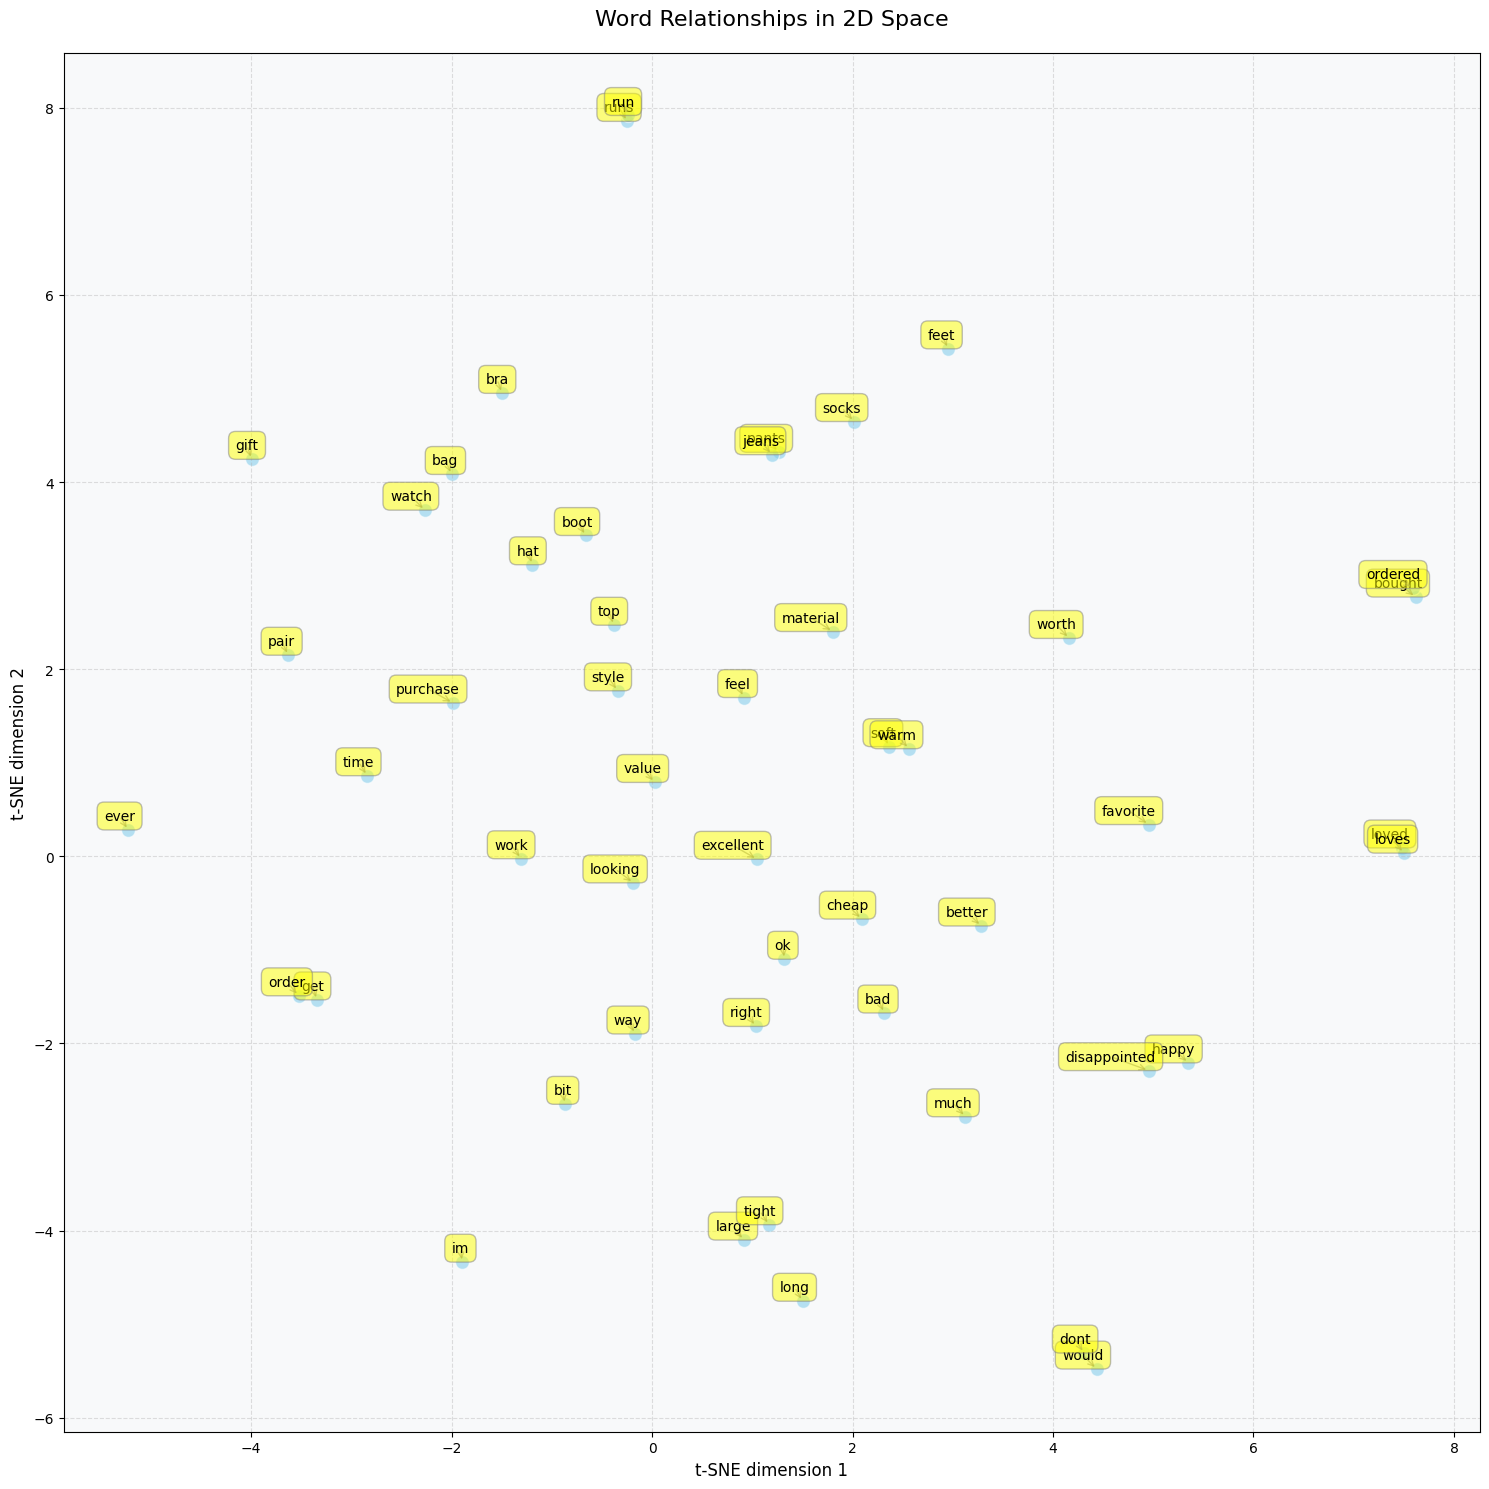

In [11]:
# Use word2vec for better word relationships
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

def clean_special_chars(text):
    # Remove special characters and convert to lowercase
    text = str(text).lower()
    return ''.join(e for e in text if e.isalnum() or e.isspace())

# Get the top N most frequent words from earlier analysis
N = 50  # Adjust this number as needed
top_words = [word for word, count in word_counts_filtered.most_common(N)]

# Create sentences for training (using your existing cleaned content)
sentences = [clean_special_chars(str(content)).split() for content in cleaned_content]

# Train Word2Vec model with more robust parameters
model = Word2Vec(sentences=sentences,
                vector_size=100,
                window=5,
                min_count=1,
                workers=4,
                seed=42)

# Get word vectors for top words that exist in the model
word_vectors = []
words = []
for word in top_words:
    if word in model.wv:
        word_vectors.append(model.wv[word])
        words.append(word)

# Convert word vectors to numpy array
word_vectors_array = np.array(word_vectors)

# Calculate appropriate perplexity
n_samples = len(word_vectors_array)
perplexity_value = min(30, max(5, n_samples // 3))

# Convert word vectors to 2D using t-SNE with better parameters
tsne = TSNE(n_components=2,
            perplexity=perplexity_value,
            n_iter=2500,
            random_state=42,
            init='pca')  # Use PCA initialization for better results

word_vectors_2d = tsne.fit_transform(word_vectors_array)

# Create enhanced visualization
plt.figure(figsize=(15, 15))

# Create scatter plot with better visibility
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], 
           c='skyblue', s=100, alpha=0.6, edgecolors='white')

# Add word labels with improved styling
for i, word in enumerate(words):
    plt.annotate(word, 
                xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
                xytext=(5, 5), 
                textcoords='offset points',
                ha='right',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', 
                        fc='yellow', 
                        ec='gray',
                        alpha=0.5,
                        linewidth=1),
                arrowprops=dict(arrowstyle='->', 
                              connectionstyle='arc3,rad=0',
                              color='gray',
                              alpha=0.6))

# Enhance plot styling
plt.title('Word Relationships in 2D Space', fontsize=16, pad=20)
plt.xlabel('t-SNE dimension 1', fontsize=12)
plt.ylabel('t-SNE dimension 2', fontsize=12)

# Add grid with better styling
plt.grid(True, linestyle='--', alpha=0.4)

# Add a light background color for better contrast
plt.gca().set_facecolor('#f8f9fa')
plt.grid(True, linestyle='--', alpha=0.4)

# Tight layout to prevent label cutoff
plt.tight_layout()

plt.show()

2024-12-02 20:34:01,740 - Loading data...
2024-12-02 20:34:12,279 - Loaded 1250990 rows of data
2024-12-02 20:34:12,279 - Handling missing values...
2024-12-02 20:34:12,395 - After handling missing values: 1250990 rows remaining
2024-12-02 20:34:12,396 - Engineering features...
2024-12-02 20:34:12,396 - Performing category frequency encoding...
2024-12-02 20:34:12,533 - Scaling features...
2024-12-02 20:34:12,562 - 
Finding optimal number of clusters...
Testing different k values:   0%|          | 0/9 [00:00<?, ?it/s]2024-12-02 20:34:12,568 - 
Testing k=2
2024-12-02 20:34:13,933 - k=2, Silhouette Score: 0.4995
2024-12-02 20:34:13,933 - Time taken: 1.36 seconds
Testing different k values:  11%|█         | 1/9 [00:01<00:10,  1.37s/it]2024-12-02 20:34:13,935 - 
Testing k=3
2024-12-02 20:34:15,213 - k=3, Silhouette Score: 0.5786
2024-12-02 20:34:15,214 - Time taken: 1.28 seconds
Testing different k values:  22%|██▏       | 2/9 [00:02<00:09,  1.32s/it]2024-12-02 20:34:15,214 - 
Testing k=4


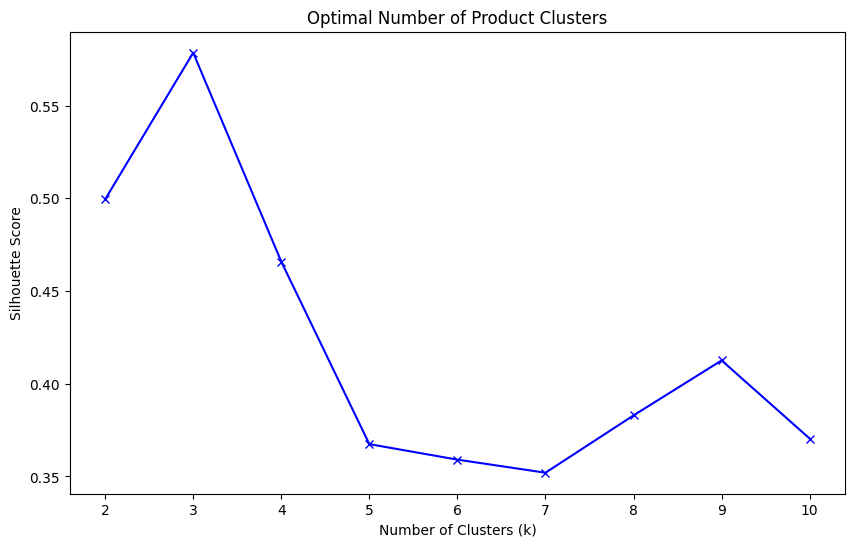

2024-12-02 20:34:23,715 - 
Optimal number of clusters: 3
2024-12-02 20:34:23,715 - Performing final clustering...
2024-12-02 20:34:24,094 - 
Analyzing clusters...
2024-12-02 20:34:24,271 - 
Training model to predict great products...



Cluster Analysis:
--------------------------------------------------

Cluster 0:
Size: 317212 products
Average Rating: 4.19
Average Price: $20.62
Percentage of Great Products: 77.7%
Top Categories:
  - Clothing Shoes Jewelry Women Clothing Lingerie Sleep Lounge: 69186 products
  - Clothing Shoes Jewelry Novelty More Clothing Novelty: 57984 products
  - Clothing Shoes Jewelry Women Shoes Sandals: 46524 products

Cluster 1:
Size: 778512 products
Average Rating: 4.29
Average Price: $18.59
Percentage of Great Products: 80.8%
Top Categories:
  - Clothing Shoes Jewelry Men Clothing Shirts: 20800 products
  - Clothing Shoes Jewelry Men Clothing Jeans: 18897 products
  - Clothing Shoes Jewelry Women Jewelry Necklaces: 18658 products

Cluster 2:
Size: 155266 products
Average Rating: 4.37
Average Price: $123.28
Percentage of Great Products: 83.8%
Top Categories:
  - Clothing Shoes Jewelry Men Shoes Athletic: 14570 products
  - Clothing Shoes Jewelry Women Shoes Flats: 13382 products
  - Clothin

C:\Users\mfave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mfave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mfave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

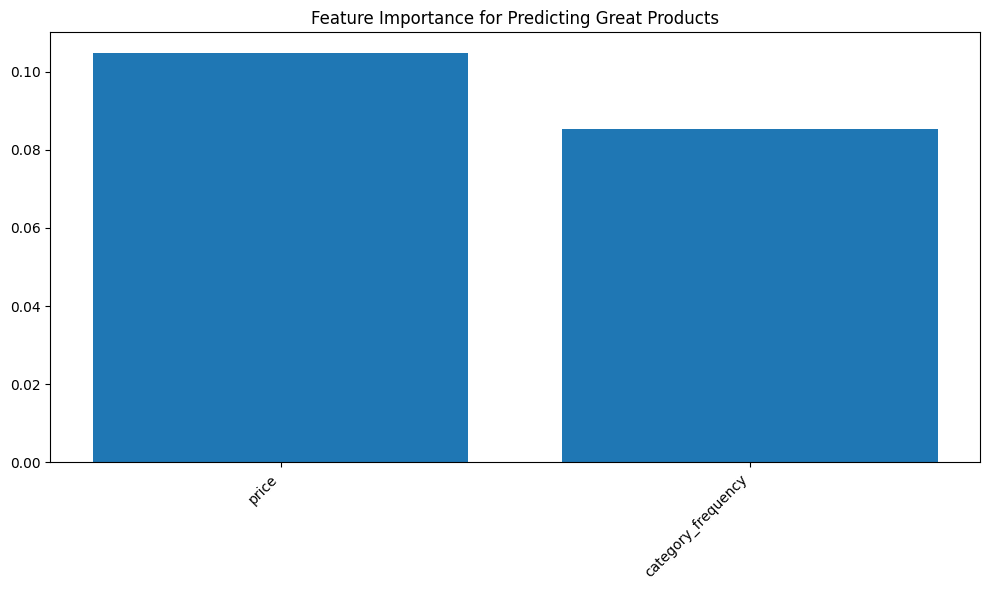

2024-12-02 20:34:26,106 - Analysis complete!



Top Factors Contributing to Great Products:
--------------------------------------------------
price: 0.1048
category_frequency: 0.0853


In [17]:
# Analysis of what makes great products
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans  # Changed from KMeans to MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
import time

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

# Load the cleaned DataFrame
logger.info("Loading data...")
df = pd.read_csv('cleaned_purchase_history.csv')
logger.info(f"Loaded {len(df)} rows of data")

# Handle missing values
logger.info("Handling missing values...")
df = df.dropna(subset=['review_rating', 'price'])
logger.info(f"After handling missing values: {len(df)} rows remaining")

# Feature Engineering
logger.info("Engineering features...")

# 1. Numerical Features
numerical_features = ['price']

# 2. Categorical Features - Use category frequency encoding instead of one-hot
logger.info("Performing category frequency encoding...")
category_frequencies = df['category'].value_counts(normalize=True)
df['category_freq'] = df['category'].map(category_frequencies)

# 3. Create binary feature for high-rated products (rating >= 4)
df['is_great_product'] = (df['review_rating'] >= 4).astype(int)

# Combine features more efficiently
X = df[['price', 'category_freq']].values
feature_names = ['price', 'category_frequency']

# Scale features
logger.info("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Part 1: K-means Clustering with MiniBatchKMeans
logger.info("\nFinding optimal number of clusters...")
silhouette_scores = []
K = range(2, 11)
sample_size = min(10000, len(X_scaled))  # Use a sample for silhouette score calculation

# Using tqdm for progress bar during clustering
for k in tqdm(K, desc="Testing different k values"):
    logger.info(f"\nTesting k={k}")
    start_time = time.time()
    
    # Use MiniBatchKMeans instead of regular KMeans
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    kmeans.fit(X_scaled)
    
    # Calculate silhouette score on a sample
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    score = silhouette_score(X_scaled[sample_indices], 
                           kmeans.predict(X_scaled[sample_indices]),
                           sample_size=sample_size)
    silhouette_scores.append(score)
    logger.info(f"k={k}, Silhouette Score: {score:.4f}")
    logger.info(f"Time taken: {time.time() - start_time:.2f} seconds")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Product Clusters')
plt.show()

# Get optimal k and perform final clustering
optimal_k = K[np.argmax(silhouette_scores)]
logger.info(f"\nOptimal number of clusters: {optimal_k}")

logger.info("Performing final clustering...")
final_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=1024)
cluster_labels = final_kmeans.fit_predict(X_scaled)
df['cluster'] = cluster_labels

# Analyze clusters
logger.info("\nAnalyzing clusters...")
cluster_stats = []
for i in range(optimal_k):
    cluster_df = df[df['cluster'] == i]
    stats = {
        'cluster': i,
        'size': len(cluster_df),
        'avg_rating': cluster_df['review_rating'].mean(),
        'avg_price': cluster_df['price'].mean(),
        'pct_great_products': (cluster_df['is_great_product'].mean() * 100),
        'top_categories': cluster_df['category'].value_counts().head(3).to_dict()
    }
    cluster_stats.append(stats)

# Print cluster insights
print("\nCluster Analysis:")
print("-" * 50)
for stats in cluster_stats:
    print(f"\nCluster {stats['cluster']}:")
    print(f"Size: {stats['size']} products")
    print(f"Average Rating: {stats['avg_rating']:.2f}")
    print(f"Average Price: ${stats['avg_price']:.2f}")
    print(f"Percentage of Great Products: {stats['pct_great_products']:.1f}%")
    print("Top Categories:")
    for cat, count in stats['top_categories'].items():
        print(f"  - {cat}: {count} products")

# Part 2: Predict Great Products
logger.info("\nTraining model to predict great products...")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df['is_great_product'], test_size=0.2, random_state=42
)

# Define the parameter grid for LogisticRegression
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Train model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

# Print model performance
print("\nModel Performance for Predicting Great Products:")
print("-" * 50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': abs(grid_search.best_estimator_.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance['importance'])
plt.xticks(range(len(feature_importance)), feature_importance['feature'], rotation=45, ha='right')
plt.title('Feature Importance for Predicting Great Products')
plt.tight_layout()
plt.show()

# Print top factors for great products
print("\nTop Factors Contributing to Great Products:")
print("-" * 50)
for _, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

logger.info("Analysis complete!")